In [1]:
from dotenv import load_dotenv
load_dotenv()

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)
response = llm.invoke("What is the capital of France?")
print(response.content)

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)
response = llm.invoke("What is the capital of France?")
print(response.content)

from langchain_core.messages import HumanMessage, SystemMessage
messages = [
    SystemMessage(content="You are a helpful assistant that can answer questions about the weather."),
    HumanMessage(content="What is the weather in Tokyo?")
]

response = llm.invoke(messages)
print(response.content)


The capital of France is Paris.
The capital of France is Paris.
I'm unable to provide real-time weather updates. However, you can easily check the current weather in Tokyo by using a weather website or app, or by searching "Tokyo weather" in your preferred search engine. If you need historical weather information or general climate information about Tokyo, feel free to ask!


In [2]:
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun

@tool
def calculator(expression: str) -> str:
    """Calculate mathematical expressions. Allways use this for any math calculations."""
    try:
        result = eval(expression)
        return f"The result of the expression {expression} is {result}"
    except Exception as e:
        return f"Error calcuating {expression}: {e}"
    

search_tool = DuckDuckGoSearchRun()

# Bind tools to the LLM
tools = [calculator, search_tool]
llm_with_tools = llm.bind_tools(tools)

print("Testing calculator tool")
response = llm_with_tools.invoke("What is 25 * 4 + 17?")
print(response.content)

Testing calculator tool



In [3]:
response.dict()

C:\Users\DELL\AppData\Local\Temp\ipykernel_11936\3202056457.py:1: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  response.dict()


{'content': '',
 'additional_kwargs': {'tool_calls': [{'id': 'call_HK9sGxYxN6fLJPL6LwUi0Who',
    'function': {'arguments': '{"expression":"25 * 4 + 17"}',
     'name': 'calculator'},
    'type': 'function'}],
  'refusal': None},
 'response_metadata': {'token_usage': {'completion_tokens': 20,
   'prompt_tokens': 110,
   'total_tokens': 130,
   'completion_tokens_details': {'accepted_prediction_tokens': 0,
    'audio_tokens': 0,
    'reasoning_tokens': 0,
    'rejected_prediction_tokens': 0},
   'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
  'model_name': 'gpt-4o-mini-2024-07-18',
  'system_fingerprint': 'fp_34a54ae93c',
  'id': 'chatcmpl-C3Lu09vJDwIqBa0OmuV0eO4YCFNbI',
  'service_tier': 'default',
  'finish_reason': 'tool_calls',
  'logprobs': None},
 'type': 'ai',
 'name': None,
 'id': 'run--43d59e73-d167-4ed9-9e0f-11def887dae0-0',
 'example': False,
 'tool_calls': [{'name': 'calculator',
   'args': {'expression': '25 * 4 + 17'},
   'id': 'call_HK9sGxYxN6fLJPL6Lw

In [4]:
response.tool_calls

[{'name': 'calculator',
  'args': {'expression': '25 * 4 + 17'},
  'id': 'call_HK9sGxYxN6fLJPL6LwUi0Who',
  'type': 'tool_call'}]

In [5]:
tool_map = {
    "calculator": calculator,
    "duckduckgo_search": DuckDuckGoSearchRun()
}

In [6]:
def handle_tool_calls(response, tool_map):
    """Executes all tool calls in the LLM response using the tool map."""
    if not getattr(response, "tool_calls", None):
        return response
    print(f"Tool calls requested: {len(response.tool_calls)}")
    for tool_call in response.tool_calls:
        tool_name = tool_call["name"]
        args = tool_call["args"]

        print(f"Tool: {tool_name}")
        print(f"Args: {args}")
        
        tool = tool_map.get(tool_name)
        if tool:
            result = tool.invoke(args)
            preview = result[:200] + "..." if isinstance(result, str) and len(result) > 200 else result
            print(f"Tool result: {preview}")

In [7]:
def test_llm_tool(query):
    print(f"Query: {query}")
    response = llm_with_tools.invoke(query)
    print(f"Response: {getattr(response, 'content', response)}")
    handle_tool_calls(response, tool_map)
    print("\n")


test_llm_tool("What is 25 * 4 + 17?")
test_llm_tool("Search for the latest news abount Artificial Intelligence.")

Query: What is 25 * 4 + 17?
Response: 
Tool calls requested: 1
Tool: calculator
Args: {'expression': '25 * 4 + 17'}
Tool result: The result of the expression 25 * 4 + 17 is 117


Query: Search for the latest news abount Artificial Intelligence.
Response: 
Tool calls requested: 1
Tool: duckduckgo_search
Args: {'query': 'latest news about Artificial Intelligence'}


c:\Portfolio\langgraph_exploration\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


Tool result: Find contact information for Mindpy. Learn about their Mental Health & Rehabilitation Facilities, Healthcare Services market … Homepage > Grocery Retail > Indya Foods Company Name Indya Foods Main Ind...




Structured Output

In [8]:
from pydantic import BaseModel, Field
from typing import List, Optional

class PersonInfo(BaseModel):
    """Information about a person."""
    name: str = Field(description="The full name of the person.")
    age: int = Field(description="The age of the person.")
    occupation: Optional[str] = Field(description="The occupation of the person.")
    skills: List[str] = Field(description="The skills of the person.")

structured_llm = llm.with_structured_output(PersonInfo)


#Test with person info
print("Testing structured output")

person_prompt = """
Extract information about the person:
"John Smith is 30 years old and works as a software engineer. He is skilled in Python, SQL, and machine learning."
"""

response = structured_llm.invoke(person_prompt)
print(response)


print("Name: ", response.name)
print("Age: ", response.age)
print("Occupation: ", response.occupation)
print("Skills: ", ", ".join(response.skills))

Testing structured output
name='John Smith' age=30 occupation='software engineer' skills=['Python', 'SQL', 'machine learning']
Name:  John Smith
Age:  30
Occupation:  software engineer
Skills:  Python, SQL, machine learning


Langgraph Básico

In [9]:
from typing import Annotated, TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)

In [10]:
def chatbot_node(state: State) -> State:
    """The main chatbot node that processes messages and generates responses."""
    response = llm.invoke(state["messages"])
    return {"messages": [response]}

print("Chatbot node function created")

Chatbot node function created


In [11]:
from langgraph.graph import StateGraph, START, END

In [12]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot_node)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)


graph = graph_builder.compile()

In [13]:
img = graph.get_graph(xray=True).draw_mermaid_png()
with open("graph.png", "wb") as f:
    f.write(img)

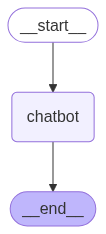

In [14]:
from IPython.display import Image, display
display(Image("graph.png"))

In [15]:
def test_chatbot(message: str):
    """Helper function to test our chatbot."""
    print(f"User: {message}")

    initial_state = {"messages": [HumanMessage(content=message)]}
    result = graph.invoke(initial_state)

    ai_response = result["messages"][-1].content
    print(f"AI: {ai_response}")
    return result

test_cases = [
    "Hello! My name is Leonardo?",
    "Do you remember my name?"
]

for test_message in test_cases:
    test_chatbot(test_message)

User: Hello! My name is Leonardo?
AI: Hello, Leonardo! How can I assist you today?
User: Do you remember my name?
AI: I don’t have the ability to remember personal information from previous interactions, including your name. However, you can tell me your name if you'd like! How can I assist you today?


In [16]:
config = {"configurable": {"thread_id": "t1"}}

# Ejecuta al menos una vez para que exista un checkpoint
graph.invoke({"messages": [{"role": "user", "content": "hola"}]}, config=config)

{'messages': [HumanMessage(content='hola', additional_kwargs={}, response_metadata={}, id='f74a5bff-a79b-4807-ad4c-376b06ae0d91'),
  AIMessage(content='¡Hola! ¿Cómo puedo ayudarte hoy?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-C3Lu7CojWfPxEk0g3T83XXh5wTCLL', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--9c4c9855-9c39-42d5-a4fa-d250c22f5d9e-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

Adding memory

In [17]:
from langgraph.checkpoint.memory import MemorySaver

In [18]:
memory = MemorySaver()

graph_with_memory = graph_builder.compile(checkpointer=memory)

print("Memory added to chatbot")

def chat_with_memory(message: str, thread_id: str):
    """Chat function with memory"""
    print(f"\n User: {message}")

    config = {"configurable": {"thread_id": thread_id}}

    initial_state = {"messages": [HumanMessage(content=message)]}
    result = graph_with_memory.invoke(initial_state, config)

    ai_response = result["messages"][-1].content
    print(f"AI: {ai_response}")
    return result

Memory added to chatbot


In [19]:
print("\n Testing Conversation with Memory:")

chat_with_memory("Hello! My name is Leonardo", thread_id="thead-1")
chat_with_memory("What is my name?", thread_id="thead-1")



 Testing Conversation with Memory:

 User: Hello! My name is Leonardo
AI: Hello, Leonardo! How can I assist you today?

 User: What is my name?
AI: Your name is Leonardo. How can I help you today?


{'messages': [HumanMessage(content='Hello! My name is Leonardo', additional_kwargs={}, response_metadata={}, id='e8b94859-4210-4268-917d-6abe1910d182'),
  AIMessage(content='Hello, Leonardo! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 13, 'total_tokens': 24, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_62a23a81ef', 'id': 'chatcmpl-C3Lu7ewzaRCHue3EkB6d8uPiAZ8P2', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--a0ef867a-b9e6-4652-9c2f-18599bd85748-0', usage_metadata={'input_tokens': 13, 'output_tokens': 11, 'total_tokens': 24, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),


In [20]:
graph_with_memory.get_state(config = {"configurable": {"thread_id": "t1"}})

StateSnapshot(values={}, next=(), config={'configurable': {'thread_id': 't1'}}, metadata=None, created_at=None, parent_config=None, tasks=(), interrupts=())

LangGraph Agent with Tools

In [21]:
from typing import TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    """State for our two-node agent"""
    messages: Annotated[list[BaseMessage], add_messages]

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)
llm_with_tools = llm.bind_tools(tools)

In [22]:
def chatbot_node(state: AgentState) -> AgentState:
    """The chatbot node decides whether to use tools or provide direct responses"""
    messages = state["messages"]


    system_message = """
    You are a helpful assistant. You have access to web search and calculator tools.

    Use the web_search tool when:
    - Asked about current events, news, or recent information.
    - Need to find specific facts or data.
    - Asked about real-time information (weather, stock prices, etc.)

    Use the calculator tool when:
    - Asked to perform mathematical calculations.
    - Need to solve math problems.

    For general knowledge questions that don't require real-time data, answer directly.
    Be helpful and conversational in your responses.
    """

    all_messages = [
        {"role": "system", "content": system_message}
    ] + messages

    response = llm_with_tools.invoke(all_messages)

    return {"messages": [response]}

In [23]:
from langgraph.prebuilt import ToolNode
from typing import Literal

In [24]:
tools

[StructuredTool(name='calculator', description='Calculate mathematical expressions. Allways use this for any math calculations.', args_schema=<class 'langchain_core.utils.pydantic.calculator'>, func=<function calculator at 0x000001AB0AB3E840>),
 DuckDuckGoSearchRun(api_wrapper=DuckDuckGoSearchAPIWrapper(region='wt-wt', safesearch='moderate', time='y', max_results=5, backend='auto', source='text'))]

In [25]:
tool_node = ToolNode(tools)
print("Tool node created")

def should_continue(state: AgentState) -> Literal["tool", "end"]:
    """
    Determine whether to continue to tools or end the conversation
    """
    messages = state["messages"]
    last_message = messages[-1]

    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools"

    return "end"


Tool node created


In [26]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

In [27]:
workflow = StateGraph(AgentState)

workflow.add_node("chatbot", chatbot_node)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "chatbot")

workflow.add_conditional_edges(
    "chatbot",
    should_continue,
    {
        "tools": "tools",
        "end": END
    }
)

workflow.add_edge("tools", "chatbot")

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

print("Graph compiled with memory \n")


Graph compiled with memory 



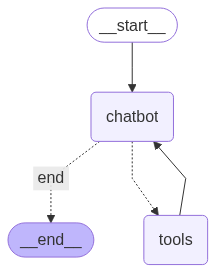

In [28]:
# Display the graph
from IPython.display import Image, display
img = app.get_graph(xray=True).draw_mermaid_png()
with open("graph.png", "wb") as f:
    f.write(img)
display(Image("graph.png"))

In [29]:
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage

def chat_with_agent(message: str, thread_id: str):
    """Chat with the two-node agent"""
    print(f"\n User: {message}")
    config = {"configurable": {"thread_id": thread_id}}

    messages_to_process = {
        "messages": [HumanMessage(content=message)]
    }

    for event in app.stream(messages_to_process, config):
        for value in event.values():
            if "messages" in value:
                last_message = value["messages"][-1]
                if hasattr(last_message, "content") and last_message.content:
                    if isinstance(last_message, AIMessage):
                        print(f"AI: {last_message.content}")
                    elif isinstance(last_message, ToolMessage):
                        print(f"Tool: {last_message.content[:100]}...")


In [30]:
questions = [
    "I am Leonardo",
    "Do you remember my name?",
    "What's 15% of 24?",
    "What are the latest news about AI?",
    "Can you tell me more about that?"
]

chat_with_agent("I am Leonardo", thread_id="thread-4")
chat_with_agent("Do you remember my name?", thread_id="thread-4")




 User: I am Leonardo
AI: Hello, Leonardo! How can I assist you today?

 User: Do you remember my name?
AI: Yes, I remember your name is Leonardo. How can I help you today?


In [31]:
chat_with_agent("What's 15% of 24?", thread_id="thread-4")



 User: What's 15% of 24?
Tool: Error calcuating 15% of 24: invalid syntax (<string>, line 1)...
Tool: The result of the expression 0.15 * 24 is 3.5999999999999996...
AI: 15% of 24 is approximately 3.6. If you need any more calculations or assistance, feel free to ask!


LangGraph RAG Agent

In [32]:
# ── Build & persist a Chroma index ────────────────────────────────
from pathlib import Path
from langchain_community.document_loaders import PyPDFLoader, Docx2txtLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma

In [33]:
SOURCE_DIR   = Path("docs")          # put your files here
INDEX_DIR    = Path("chroma_db_1")   # will be created if missing
EMBED_MODEL  = "text-embedding-3-small"

In [34]:
# Load docs (keep only pdf/docx for brevity)
docs = []
for f in SOURCE_DIR.glob("*.*"):
    print(f)
    if f.suffix == ".pdf":
        docs += PyPDFLoader(str(f)).load()
    elif f.suffix == ".docx":
        docs += Docx2txtLoader(str(f)).load()

docs\anyoneai_invoice_AzycBrUtJ0Z6R4UZ.pdf


In [54]:
docs[0]

Document(metadata={'producer': 'PD4ML. HTML to PDF Converter for Java (396)', 'creator': 'PD4ML. HTML to PDF Converter for Java (396)', 'creationdate': "D:20250808174738Z00'00'", 'source': 'docs\\anyoneai_invoice_AzycBrUtJ0Z6R4UZ.pdf', 'total_pages': 1, 'page': 0, 'page_label': '1'}, page_content='Anyone AI Inc\nWILMINGTON, Delaware 19803\nUnited States\nINVOICE\nInvoice #—0820253413\nInvoice Date—Aug 01, 2025\nInvoice Amount—$300.00 (USD)\nCustomer ID—CD-4149\nPAID\nBILLED TO\nLeonardo Burbano\nEcuador\nSUBSCRIPTION\nID—S-CD-4149\nBilling Period—Aug 01 to Aug 31, 2025\n\xa0 \nDESCRIPTION AMOUNT (USD)\n\xa0 \nApplicable (10%) Fee for your Workers Benefits Fund Income \nApplicable (10%) Fee for your Workers Benefits Fund Income\n$300.00\n\xa0 \n\xa0 \nTotal $300.00\nPayments($300.00)\n\xa0 \n\xa0 \n\xa0 \nAmount Due (USD) $0.00\n\xa0 \n\xa0 \n\xa0 \nPAYMENTS\n$300.00 (USD) was paid on 06 Aug, 2025 22:08 ART by Visa card ending 2321.\nNOTES\nQuestions? Contact us at backoffice@anyoneai.c

In [35]:
# Split & embed
chunks     = RecursiveCharacterTextSplitter(chunk_size=1_000, chunk_overlap=200).split_documents(docs)
embeddings = OpenAIEmbeddings(model=EMBED_MODEL)

vectordb = Chroma.from_documents(
    documents         = chunks,
    embedding         = embeddings,
    persist_directory = str(INDEX_DIR),
    collection_name   = "kb_collection",
)
vectordb.persist()
print("✅ Index built →", INDEX_DIR.resolve())

✅ Index built → C:\Portfolio\langgraph_exploration\notebooks\chroma_db_1


C:\Users\DELL\AppData\Local\Temp\ipykernel_11936\3694848675.py:11: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vectordb.persist()


In [36]:
retriever = vectordb.as_retriever(search_kwargs={"k": 2})

@tool
def rag_search_tool(query: str) -> str:
    """Search the knowledge‑base for relevant chunks"""
    results = retriever.invoke(query)
    return "".join(d.page_content for d in results)

In [62]:
test_query = "Invoice description"
results = rag_search_tool.invoke(test_query)
print(f"RAG results: {results}")

RAG results: Anyone AI Inc
WILMINGTON, Delaware 19803
United States
INVOICE
Invoice #—0820253413
Invoice Date—Aug 01, 2025
Invoice Amount—$300.00 (USD)
Customer ID—CD-4149
PAID
BILLED TO
Leonardo Burbano
Ecuador
SUBSCRIPTION
ID—S-CD-4149
Billing Period—Aug 01 to Aug 31, 2025
  
DESCRIPTION AMOUNT (USD)
  
Applicable (10%) Fee for your Workers Benefits Fund Income 
Applicable (10%) Fee for your Workers Benefits Fund Income
$300.00
  
  
Total $300.00
Payments($300.00)
  
  
  
Amount Due (USD) $0.00
  
  
  
PAYMENTS
$300.00 (USD) was paid on 06 Aug, 2025 22:08 ART by Visa card ending 2321.
NOTES
Questions? Contact us at backoffice@anyoneai.comAnyone AI Inc
WILMINGTON, Delaware 19803
United States
INVOICE
Invoice #—0820253413
Invoice Date—Aug 01, 2025
Invoice Amount—$300.00 (USD)
Customer ID—CD-4149
PAID
BILLED TO
Leonardo Burbano
Ecuador
SUBSCRIPTION
ID—S-CD-4149
Billing Period—Aug 01 to Aug 31, 2025
  
DESCRIPTION AMOUNT (USD)
  
Applicable (10%) Fee for your Workers Benefits Fund Inc

In [37]:
from langchain_tavily import TavilySearch

tavily = TavilySearch(max_results=3, topic="general")

@tool
def web_search_tool(query: str) -> str:
    """Up‑to‑date web info via Tavily"""
    return "".join(r["content"] for r in tavily.invoke({"query": query})["results"])  # simplified

In [71]:
class AgentState(TypedDict):
    """State for our two-node agent"""
    messages: Annotated[list[BaseMessage], add_messages]
    route: str # "rag", "answer", "web", "end"
    rag: str | None   # KB result
    web: str | None   # web‑search snippets

In [72]:
# ── Structured helpers ─────────────────
class RouteDecision(BaseModel):
    route: Literal["rag", "answer", "end"]
    reply: str | None = None

class RagJudge(BaseModel):
    sufficient: bool

router_llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0).with_structured_output(RouteDecision)
judge_llm  = ChatOpenAI(model="gpt-4.1-mini", temperature=0).with_structured_output(RagJudge)
answer_llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0.7)

In [73]:
# Fix the router with better prompting
def router_node(state: AgentState) -> AgentState:
    q = state["messages"][-1].content
    decision = router_llm.invoke([
        ("system", """You are a routing system. Analyze the user's question and decide the best route:

- Use "rag" for questions about documents, files, knowledge base content, or when user explicitly asks to search documents
- Use "answer" for general knowledge questions, math problems, or questions that don't need external search
- Use "end" only for greetings or conversation starters

Examples:
- "Search in the knowledge-base, What's the description of the Invoice #0820253413?" → "rag" (document search)
- "What's 15% of 24?" → "answer" (math calculation)
- "What's in my documents?" → "rag" (document search)
- "Hello" → "end" (greeting)

Respond with the appropriate route."""),
        ("user", q)
    ])
    new_state = {**state, "route": decision.route}
    if decision.route == "end":
        new_state["messages"] += [AIMessage(content=decision.reply or "Hello!")]
    return new_state

In [74]:
# Test the router directly
test_state = {
    "messages": [HumanMessage(content="Search in the knowledge-base, What's the description of the Invoice #0820253413?")],
    "route": "",
    "rag": None,
    "web": None
}
router_result = router_node(test_state)
print(f"Router decision: {router_result['route']}")

Router decision: rag


In [75]:
# ── RAG lookup ─────────────────────────
def rag_node(state: AgentState) -> AgentState:
    q = state["messages"][-1].content
    chunks = rag_search_tool.invoke(q)
    print(f"📄 RAG found chunks: {len(chunks)} characters")
    verdict = judge_llm.invoke([("user", f"Question: {q}\nDocs: {chunks[:300]}…")])
    print(f"⚖️ RAG judge verdict: {verdict.sufficient}")
    result = {**state, "rag": chunks, "route": "answer" if verdict.sufficient else "web"}
    print(f"📤 RAG node output: route={result['route']}")
    return result


In [76]:
# ── Web search ──────────────────────────
def web_node(state: AgentState) -> AgentState:
    q = state["messages"][-1].content
    web = web_search_tool.invoke(q)
    return {**state, "web": web, "route": "answer"}

# ── Answer ──────────────────────────────
def answer_node(state: AgentState) -> AgentState:
    q = state["messages"][-1].content
    if state["rag"] is not None:
        answer = f"Based on your documents: {state['rag']}"
        print(f"📚 Using RAG content")
    elif state["web"] is not None:
        answer = f"Based on web search: {state['web']}"
        print(f"🌐 Using web content")
    else:
        print(f"🤖 Using LLM for answer")
        response = answer_llm.invoke([
            ("system", "You are a helpful assistant. Answer the user's question clearly and accurately."),
            ("user", q)
        ])
        answer = response.content
    print(f"�� Answer node output: {len(answer)} characters")
    return {**state, "messages": [AIMessage(content=answer)]}


In [77]:
def from_router(state: AgentState) -> Literal["rag", "answer", "end"]:
    return state["route"]

In [78]:
def after_rag(state: AgentState) -> Literal["answer", "web"]:
    q = state["messages"][-1].content
    verdict = judge_llm.invoke([("user", f"Question: {q}\nDocs: {state['rag'][:300]}…")])
    return "answer" if verdict.sufficient else "web"

In [79]:
agent_graph = StateGraph(AgentState)
agent_graph.add_node("router",      router_node)
agent_graph.add_node("rag_lookup",  rag_node)
agent_graph.add_node("web_search",  web_node)
agent_graph.add_node("answer",      answer_node)

agent_graph.set_entry_point("router")
agent_graph.add_conditional_edges("router", from_router,
        {"rag": "rag_lookup", "answer": "answer", "end": END})
agent_graph.add_conditional_edges("rag_lookup", after_rag,
        {"answer": "answer", "web": "web_search"})
agent_graph.add_edge("web_search", "answer")
agent_graph.add_edge("answer", END)

agent = agent_graph.compile(checkpointer=MemorySaver())


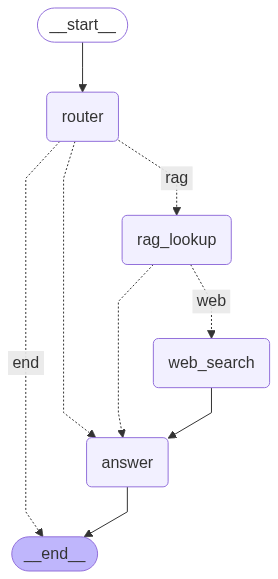

In [80]:
from IPython.display import Image, display
img = agent.get_graph(xray=True).draw_mermaid_png()
with open("graph.png", "wb") as f:
    f.write(img)
display(Image("graph.png"))

In [82]:
def test_aget_rag(agent, message: str, thread_id: str):
    config = {"configurable": {"thread_id": thread_id}}
    result = agent.invoke({"messages": [HumanMessage(content=message)]}, config)
    print(result["messages"][-1].content)

#test_aget_rag(agent, "Search in th knowledge‑base, What's the description of the Invoice #— 0820253413?", "thread‑13")